In [167]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F  # Ensure this import is added

from torch.utils.data import DataLoader, TensorDataset
import gym
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

### CNN 1 : RGB 

In [171]:
# Parameters
sequence_length = 4  # Number of images in each sequence
num_episodes = 300   ### JOUER AVEC CE PARAMETRE POUR AMELIORER LE MODELE : TESTER AVEC 1000 SERAIT COOL

# Environment Setup
env = gym.make('CartPole-v1')
data_images = []
data_states = []

# Transformation for images
transform = transforms.Compose([transforms.ToPILImage(), 
                    transforms.Resize(60, interpolation=Image.LANCZOS),
                    transforms.ToTensor()])


# Cart location for centering image crop
def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

# Cropping, downsampling (and Grayscaling) image
def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    # Resize, and add a batch dimension (BCHW)
    screen = torch.from_numpy(screen)
    return transform(screen)

In [172]:

# Data Collection using Heuristic Policy
for episode in range(num_episodes):
    observation = env.reset()
    images = [torch.zeros(3, 60, 135) for _ in range(4)]
           
    for t in range(1000):
        tensor_image = get_screen()  # Transform image immediately
        # if t==4:
        #     print(tensor_image.shape)
        #     plt.imshow(np.array(tensor_image.permute(1,2,0)))
        images.append(tensor_image)
        
        if len(images) >= sequence_length:
            # Stack the last sequence_length images to form a single sequence tensor
            sequence_tensor = torch.stack(images[-sequence_length:], dim=0).permute(1, 0, 2, 3)
            data_images.append(sequence_tensor)
            data_states.append(observation)
        
        action = env.action_space.sample()  
        observation, reward, done, info = env.step(action)
        if done:
            break

env.close()

# Convert data_states to a tensor
data_states = torch.tensor(data_states, dtype=torch.float32)

# Dataset and DataLoader
dataset = TensorDataset(torch.stack(data_images), data_states)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)


In [173]:
# Model Definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv3d(3, 16, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
        )
        # Correctly calculate the input size for the linear layer based on the output from conv_layers
        self.fc_layers = nn.Sequential(
            nn.Linear(63360, 128),  # Adjusted based on actual output size
            nn.ReLU(),
            nn.Linear(128, 4)  # Predicting 4 state variables
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = self.fc_layers(x)
        return x

In [174]:
# Model instantiation and training setup
model = CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10 # Peut-être avec plus d'epoch on obtiendrait un meilleur résultat ? jsp
for epoch in range(num_epochs):
    for images, states in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, states)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')



Epoch 1, Loss: 0.07291144877672195
Epoch 2, Loss: 0.0323127880692482
Epoch 3, Loss: 0.0680825263261795
Epoch 4, Loss: 0.014706824906170368
Epoch 5, Loss: 0.011884740553796291
Epoch 6, Loss: 0.06468658894300461
Epoch 7, Loss: 0.033202096819877625
Epoch 8, Loss: 0.03171757236123085
Epoch 9, Loss: 0.04470457136631012
Epoch 10, Loss: 0.07456962764263153


In [175]:
# Save the model
torch.save(model.state_dict(), 'cartpole_cnn_rgb.pth')

In [179]:
# Voir un peu ce que ça donne

model.eval()
for images, states in dataloader:
    print(images.shape,states.shape)
    print(model(images[0].unsqueeze(0)),states[0])
    break

torch.Size([10, 3, 4, 60, 135]) torch.Size([10, 4])
tensor([[ 0.0022,  0.0096, -0.0036,  0.0202]], grad_fn=<AddmmBackward0>) tensor([ 0.0405,  0.0406,  0.0216, -0.0420])


In [8]:
# Voir encore mieux ce que ça donne

# 1 : On collecte des images du cartpole (heuristique : random)

env = gym.make('CartPole-v1')
data_images_bis = []
data_states_bis = []

for episode in range(3):
    observation_bis = env.reset()
    images_bis = []
    for t in range(1000):
        img = env.render(mode='rgb_array')
        img_pil = Image.fromarray(img)
        tensor_image = transform(img_pil)  # Transform image immediately
        images_bis.append(tensor_image)
        
        if len(images_bis) >= sequence_length:
            # Stack the last sequence_length images to form a single sequence tensor
            sequence_tensor = torch.stack(images_bis[-sequence_length:], dim=0).permute(1, 0, 2, 3)
            data_images_bis.append(sequence_tensor)
            data_states_bis.append(observation)
        
        action = env.action_space.sample()   # Use the heuristic policy
        observation, reward, done, info = env.step(action)
        if done:
            break
data_states_bis = torch.tensor(data_states_bis, dtype=torch.float32)

# Dataset and DataLoader
data_images_bis = torch.stack(data_images_bis)

In [9]:
# 2 Afficher ce que prédit le modèle vs les vraies observations

model.eval()
total = 0 # Loss totale
for images, states in zip(data_images_bis, data_states_bis):
    with torch.no_grad():
        print(model(images.unsqueeze(0)),states)
        total += np.sum(np.array((model(images.unsqueeze(0))-states)**2))

print(total)

tensor([[0.0299, 0.0496, 0.0353, 0.0723]]) tensor([ 0.0389, -0.2293,  0.0359,  0.3186])
tensor([[0.0299, 0.0496, 0.0353, 0.0723]]) tensor([ 0.0343, -0.4249,  0.0423,  0.6224])
tensor([[ 0.0246, -0.2409,  0.0376,  0.4888]]) tensor([ 0.0258, -0.6206,  0.0547,  0.9281])
tensor([[-0.0030, -0.4574,  0.0725,  0.8211]]) tensor([ 0.0134, -0.4262,  0.0733,  0.6531])
tensor([[-0.0075, -0.3330,  0.0781,  0.6277]]) tensor([ 0.0048, -0.6223,  0.0864,  0.9680])
tensor([[-0.0099, -0.3732,  0.0813,  0.6977]]) tensor([-0.0076, -0.8185,  0.1057,  1.2865])
tensor([[-0.0377, -0.6290,  0.1080,  1.1038]]) tensor([-0.0240, -0.6248,  0.1315,  1.0287])
tensor([[-0.0493, -0.5892,  0.1321,  1.0962]]) tensor([-0.0365, -0.4317,  0.1520,  0.7800])
tensor([[-0.0617, -0.3433,  0.1516,  0.8059]]) tensor([-0.0451, -0.6285,  0.1676,  1.1164])
tensor([[-0.0767, -0.5178,  0.1705,  1.1121]]) tensor([-0.0577, -0.8254,  0.1900,  1.4566])
tensor([[ 0.0286, -0.0267,  0.0286,  0.1492]]) tensor([ 0.0384,  0.2369,  0.0298, -0.311

In [10]:
torch.save(model.state_dict(), 'gotta_test_that_one.pth')

### CNN 2 : GREY

In [76]:
# Parameters
sequence_length = 4  # Number of images in each sequence
num_episodes = 300   # Number of episodes for data collection
                     # ENCORE UNE FOIS best_grey_model A ETE FAIT A 300, VOIR AVEC 1000 ? 

# Environment Setup
env = gym.make('CartPole-v1')
data_images = []
data_states = []

# Transformer les images et les convertir en tenseurs
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((60, 135)),
    transforms.Grayscale()
])

In [11]:
# Cart location for centering image crop
def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

# Cropping, downsampling (and Grayscaling) image
def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    # Resize, and add a batch dimension (BCHW)
    return transform(screen.transpose(1,2,0)).squeeze(0)


In [77]:

# Collecter les données

for episode in range(num_episodes):
    observation = env.reset()
    images = [torch.zeros(60, 135) for _ in range(4)]
    for t in range(1000):
        img = env.render(mode='rgb_array')
        tensor_image = get_screen()
        # if t == 5:
        #     fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Crée une figure et des axes avec 1 ligne et 'n_images' colonnes
        #     axes[0].imshow(tensor_image)
        #     axes[1].imshow(tensor_image_bis)

        images.append(tensor_image)
        
        sequence_tensor = torch.stack(images[-sequence_length:], dim=0)
        data_images.append(sequence_tensor)
        data_states.append(observation)

        action = env.action_space.sample()  
        observation, reward, done, info = env.step(action)
        if done:
            break

# env.close()

# Convert data_states to a tensor
data_states = torch.tensor(data_states, dtype=torch.float32)

# Dataset and DataLoader
dataset = TensorDataset(torch.stack(data_images), data_states)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [14]:
class CartPoleCNN(nn.Module):
    def __init__(self):
        super(CartPoleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=5, stride=1, padding=2),  # Input: 4 gray images, output: 16 channels, 60x135
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output size: ? 30x67
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output size: ? 15x33
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                  # Output size: ? 7x16
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 16, 128),
            nn.ReLU(),
            nn.Linear(128,4)    # x, x_dot, theta, theta_dot
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_layers(x)
        return x

# Instanciation du modèle
model = CartPoleCNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.Size([10, 4]) torch.Size([10, 4, 60, 135])
tensor([-0.1114, -1.3923,  0.1666,  2.2089])


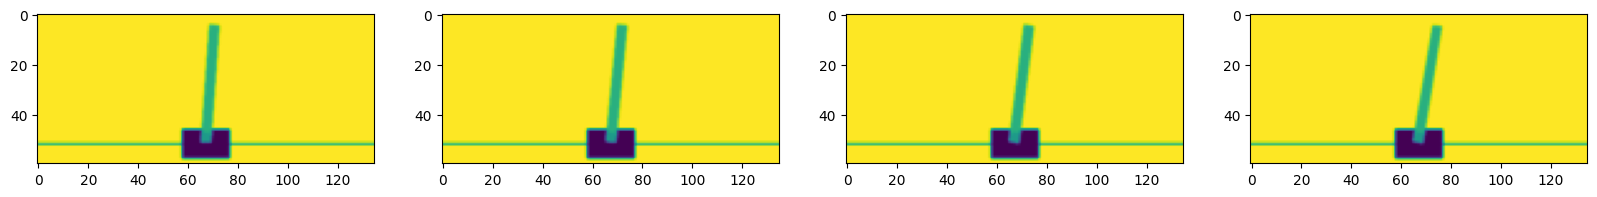

In [82]:
for images, labels in dataloader:
    print(labels.shape,images.shape)
    fig,axes = plt.subplots(1,4,figsize = (20,30))
    for i in range(4):
        axes[i].imshow(images[0][i])
    print(labels[0])

    break

In [92]:
env.close()

In [86]:
# Training Loop
num_epochs = 15 # Peut-être avec plus d'epoch on obtiendrait un meilleur résultat ? jsp
model.train()
for epoch in range(num_epochs):
    for images, states in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, states)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.4276227056980133
Epoch 2, Loss: 0.0886773020029068
Epoch 3, Loss: 0.04507780820131302
Epoch 4, Loss: 0.04576120525598526
Epoch 5, Loss: 0.05920986086130142
Epoch 6, Loss: 0.04326784983277321
Epoch 7, Loss: 0.08375322818756104
Epoch 8, Loss: 0.05944535881280899
Epoch 9, Loss: 0.017115509137511253
Epoch 10, Loss: 0.05878958851099014
Epoch 11, Loss: 0.04696138575673103
Epoch 12, Loss: 0.039336491376161575
Epoch 13, Loss: 0.04241881147027016
Epoch 14, Loss: 0.02552243508398533
Epoch 15, Loss: 0.07572563737630844


In [87]:
# Voir encore mieux ce que ça donne

# 1 : On collecte des images du cartpole (heuristique : random)

env = gym.make('CartPole-v1')
data_images_bis = []
data_states_bis = []

for episode in range(3):
    observation_bis = env.reset()
    images_bis = []
    for t in range(1000):
        img = env.render(mode='rgb_array')
        tensor_image = transform(img).squeeze(0)  # Transform image immediately
        images_bis.append(tensor_image)
        
        if len(images_bis) >= sequence_length:
            # Stack the last sequence_length images to form a single sequence tensor
            sequence_tensor = torch.stack(images_bis[-sequence_length:], dim=0)
            data_images_bis.append(sequence_tensor)
            data_states_bis.append(observation)
        
        action = env.action_space.sample()   # Use the heuristic policy
        observation, reward, done, info = env.step(action)
        if done:
            break
data_states_bis = torch.tensor(data_states_bis, dtype=torch.float32)

# Dataset and DataLoader
data_images_bis = torch.stack(data_images_bis)

In [90]:
# 2 Afficher ce que prédit le modèle vs les vraies observations

model.eval()
total = 0 # Loss totale
for images, states in zip(data_images_bis, data_states_bis):
    with torch.no_grad():
        print(model(images.unsqueeze(0)),states)
        total += np.sum(np.array((model(images.unsqueeze(0))-states)**2))

print(total)

tensor([[-0.0013,  0.0514,  0.0029, -0.0560]]) tensor([ 0.0065, -0.6055,  0.0538,  0.9156])
tensor([[-0.0009,  0.0634,  0.0017, -0.0747]]) tensor([-0.0056, -0.4112,  0.0722,  0.6403])
tensor([[-0.0012,  0.0543,  0.0026, -0.0605]]) tensor([-0.0138, -0.2171,  0.0850,  0.3712])
tensor([[-0.0005,  0.0730,  0.0008, -0.0895]]) tensor([-0.0181, -0.0233,  0.0924,  0.1064])
tensor([[-2.5229e-04,  8.0552e-02,  6.5079e-05, -1.0122e-01]]) tensor([-0.0186, -0.2196,  0.0945,  0.4268])
tensor([[-0.0004,  0.0769,  0.0004, -0.0955]]) tensor([-0.0230, -0.4159,  0.1031,  0.7477])
tensor([[-0.0009,  0.0621,  0.0018, -0.0726]]) tensor([-0.0313, -0.6123,  0.1180,  1.0709])
tensor([[-0.0014,  0.0486,  0.0031, -0.0517]]) tensor([-0.0436, -0.4189,  0.1394,  0.8175])
tensor([[-0.0013,  0.0516,  0.0028, -0.0563]]) tensor([-0.0519, -0.6157,  0.1558,  1.1506])
tensor([[-0.0015,  0.0450,  0.0035, -0.0461]]) tensor([-0.0643, -0.4229,  0.1788,  0.9105])
tensor([[-0.0013,  0.0511,  0.0029, -0.0556]]) tensor([-0.0727, 

In [91]:
torch.save(model.state_dict(), 'cnn_batchnorm.pth')

In [75]:
env.close()